## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# # 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna
# !apt install -y libgl1-mesa-glx
# !pip install albumentations

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'
# model_name = 'convnextv2_base.fcmae_ft_in22k_in1k_384'
# model_name = 'vit_base_patch16_clip_384.laion2b_ft_in12k_in1k' # openclip
# model_name = 'vit_base_patch16_384.augreg_in1k' # augreg
# model_name = 'eva02_enormous_patch14_plus_clip_224.laion2b_s9b_b144k' # eva-02 멀티모달
# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용
# model_name = 'vit_base_patch14_reg4_dinov2.lvd142m' # dinov2 reg4

# model_name = 'eva02_large_patch14_448.mim_in22k_ft_in1k' #448 테스트용

# training config
img_size = 384
LR = 2e-4
EPOCHS = 10
BATCH_SIZE = 24
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [8]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [9]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [10]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.7043: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]

Epoch  1 | Train Loss: 2.1714 | Train F1: 0.3167 | Val Loss: 1.1284 | Val F1: 0.6849



Val Loss: 1.5191: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


Epoch  2 | Train Loss: 1.4073 | Train F1: 0.5418 | Val Loss: 0.8987 | Val F1: 0.7746


Val Loss: 1.1930: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch  3 | Train Loss: 1.0131 | Train F1: 0.6831 | Val Loss: 0.7150 | Val F1: 0.8481


Val Loss: 1.3854: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch  4 | Train Loss: 0.9164 | Train F1: 0.6982 | Val Loss: 0.7124 | Val F1: 0.8583


Val Loss: 0.7129: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


Epoch  5 | Train Loss: 0.9047 | Train F1: 0.7405 | Val Loss: 0.7554 | Val F1: 0.7849


Val Loss: 0.8230: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


Epoch  6 | Train Loss: 0.8798 | Train F1: 0.6928 | Val Loss: 0.5860 | Val F1: 0.9020


Val Loss: 1.1953: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


Epoch  7 | Train Loss: 0.7057 | Train F1: 0.7420 | Val Loss: 0.6002 | Val F1: 0.8758


Val Loss: 0.6968: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Epoch  8 | Train Loss: 0.7386 | Train F1: 0.8181 | Val Loss: 0.5428 | Val F1: 0.8753


Val Loss: 0.9423: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch  9 | Train Loss: 0.7938 | Train F1: 0.7895 | Val Loss: 0.5602 | Val F1: 0.8839


Val Loss: 0.9153: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Epoch 10 | Train Loss: 0.7683 | Train F1: 0.7512 | Val Loss: 0.5549 | Val F1: 0.9094
Fold 1 Best Validation F1: 0.9094

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.3635: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Epoch  1 | Train Loss: 2.0860 | Train F1: 0.3663 | Val Loss: 1.1425 | Val F1: 0.6932


Val Loss: 0.8488: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


Epoch  2 | Train Loss: 1.2818 | Train F1: 0.5534 | Val Loss: 0.8129 | Val F1: 0.7876


Val Loss: 0.8132: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


Epoch  3 | Train Loss: 0.9959 | Train F1: 0.6858 | Val Loss: 0.6531 | Val F1: 0.8361


Val Loss: 1.2741: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Epoch  4 | Train Loss: 0.8455 | Train F1: 0.7298 | Val Loss: 0.7414 | Val F1: 0.8200


Val Loss: 1.2360: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


Epoch  5 | Train Loss: 0.7628 | Train F1: 0.8100 | Val Loss: 0.5875 | Val F1: 0.8829


Val Loss: 1.0089: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch  6 | Train Loss: 0.6421 | Train F1: 0.8338 | Val Loss: 0.5843 | Val F1: 0.8621


Val Loss: 0.7515: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Epoch  7 | Train Loss: 0.7405 | Train F1: 0.7969 | Val Loss: 0.5551 | Val F1: 0.9051


Val Loss: 0.5406: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Epoch  8 | Train Loss: 0.6453 | Train F1: 0.8471 | Val Loss: 0.5128 | Val F1: 0.9102


Val Loss: 0.9389: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


Epoch  9 | Train Loss: 0.6632 | Train F1: 0.8464 | Val Loss: 0.5480 | Val F1: 0.8951


Val Loss: 0.6515: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


Epoch 10 | Train Loss: 0.7357 | Train F1: 0.7731 | Val Loss: 0.5167 | Val F1: 0.9127
Fold 2 Best Validation F1: 0.9127

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3553: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

Epoch  1 | Train Loss: 2.0173 | Train F1: 0.3786 | Val Loss: 1.1520 | Val F1: 0.6343



Val Loss: 0.3532: 100%|██████████| 14/14 [00:05<00:00,  2.80it/s]

Epoch  2 | Train Loss: 1.2808 | Train F1: 0.5721 | Val Loss: 0.8004 | Val F1: 0.7832



Val Loss: 0.3326: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Epoch  3 | Train Loss: 1.0788 | Train F1: 0.6451 | Val Loss: 0.6849 | Val F1: 0.8119


Val Loss: 0.3250: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Epoch  4 | Train Loss: 0.8573 | Train F1: 0.7590 | Val Loss: 0.5760 | Val F1: 0.8832


Val Loss: 0.3379: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Epoch  5 | Train Loss: 0.8049 | Train F1: 0.7773 | Val Loss: 0.5517 | Val F1: 0.8621


Val Loss: 0.3376: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


Epoch  6 | Train Loss: 0.8139 | Train F1: 0.7408 | Val Loss: 0.5757 | Val F1: 0.8473


Val Loss: 0.3285: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

Epoch  7 | Train Loss: 0.8143 | Train F1: 0.6922 | Val Loss: 0.5188 | Val F1: 0.8938



Val Loss: 0.3249: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


Epoch  8 | Train Loss: 0.6693 | Train F1: 0.8568 | Val Loss: 0.5153 | Val F1: 0.8752


Val Loss: 0.3262: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


Epoch  9 | Train Loss: 0.6660 | Train F1: 0.7640 | Val Loss: 0.4808 | Val F1: 0.9163


Val Loss: 0.3254: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Epoch 10 | Train Loss: 0.6875 | Train F1: 0.8367 | Val Loss: 0.4934 | Val F1: 0.9010
Fold 3 Best Validation F1: 0.9163

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3942: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

Epoch  1 | Train Loss: 1.7843 | Train F1: 0.4704 | Val Loss: 0.8842 | Val F1: 0.7304



Val Loss: 0.3318: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


Epoch  2 | Train Loss: 0.9787 | Train F1: 0.6771 | Val Loss: 0.6367 | Val F1: 0.8374


Val Loss: 0.3291: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

Epoch  3 | Train Loss: 0.8519 | Train F1: 0.7677 | Val Loss: 0.5536 | Val F1: 0.8597



Val Loss: 0.3260: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


Epoch  4 | Train Loss: 0.8425 | Train F1: 0.7275 | Val Loss: 0.5480 | Val F1: 0.8540


Val Loss: 0.3260: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch  5 | Train Loss: 0.7611 | Train F1: 0.7875 | Val Loss: 0.5283 | Val F1: 0.8901


Val Loss: 0.3273: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch  6 | Train Loss: 0.7685 | Train F1: 0.7370 | Val Loss: 0.5644 | Val F1: 0.8688


Val Loss: 0.3275: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Epoch  7 | Train Loss: 0.7006 | Train F1: 0.8446 | Val Loss: 0.4921 | Val F1: 0.9266


Val Loss: 0.3273: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


Epoch  8 | Train Loss: 0.7152 | Train F1: 0.8196 | Val Loss: 0.4969 | Val F1: 0.9130


Val Loss: 0.3245: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


Epoch  9 | Train Loss: 0.6713 | Train F1: 0.8687 | Val Loss: 0.4791 | Val F1: 0.9206


Val Loss: 0.3257: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


Epoch 10 | Train Loss: 0.5997 | Train F1: 0.8943 | Val Loss: 0.4868 | Val F1: 0.9230
Fold 4 Best Validation F1: 0.9266

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3756: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

Epoch  1 | Train Loss: 1.9581 | Train F1: 0.3852 | Val Loss: 0.9913 | Val F1: 0.6786



Val Loss: 0.3368: 100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


Epoch  2 | Train Loss: 1.0871 | Train F1: 0.6481 | Val Loss: 0.6889 | Val F1: 0.8262


Val Loss: 0.3345: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

Epoch  3 | Train Loss: 0.9297 | Train F1: 0.7301 | Val Loss: 0.6268 | Val F1: 0.8338



Val Loss: 0.3337: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

Epoch  4 | Train Loss: 0.7388 | Train F1: 0.7914 | Val Loss: 0.6181 | Val F1: 0.8618



Val Loss: 0.3260: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch  5 | Train Loss: 0.8233 | Train F1: 0.7676 | Val Loss: 0.5485 | Val F1: 0.8886


Val Loss: 0.3255: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


Epoch  6 | Train Loss: 0.7224 | Train F1: 0.8004 | Val Loss: 0.5073 | Val F1: 0.9050


Val Loss: 0.3321: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Epoch  7 | Train Loss: 0.7847 | Train F1: 0.7892 | Val Loss: 0.5285 | Val F1: 0.8985


Val Loss: 0.3288: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


Epoch  8 | Train Loss: 0.6355 | Train F1: 0.8651 | Val Loss: 0.5354 | Val F1: 0.8827


Val Loss: 0.3245: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


Epoch  9 | Train Loss: 0.7464 | Train F1: 0.7471 | Val Loss: 0.5033 | Val F1: 0.9012


Val Loss: 0.3319: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

Epoch 10 | Train Loss: 0.6384 | Train F1: 0.8259 | Val Loss: 0.5046 | Val F1: 0.9105


Fold 5 Best Validation F1: 0.9105

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9094
Fold 2: 0.9127
Fold 3: 0.9163
Fold 4: 0.9266
Fold 5: 0.9105

Mean CV F1: 0.9151 ± 0.0062
Best single fold: 0.9266


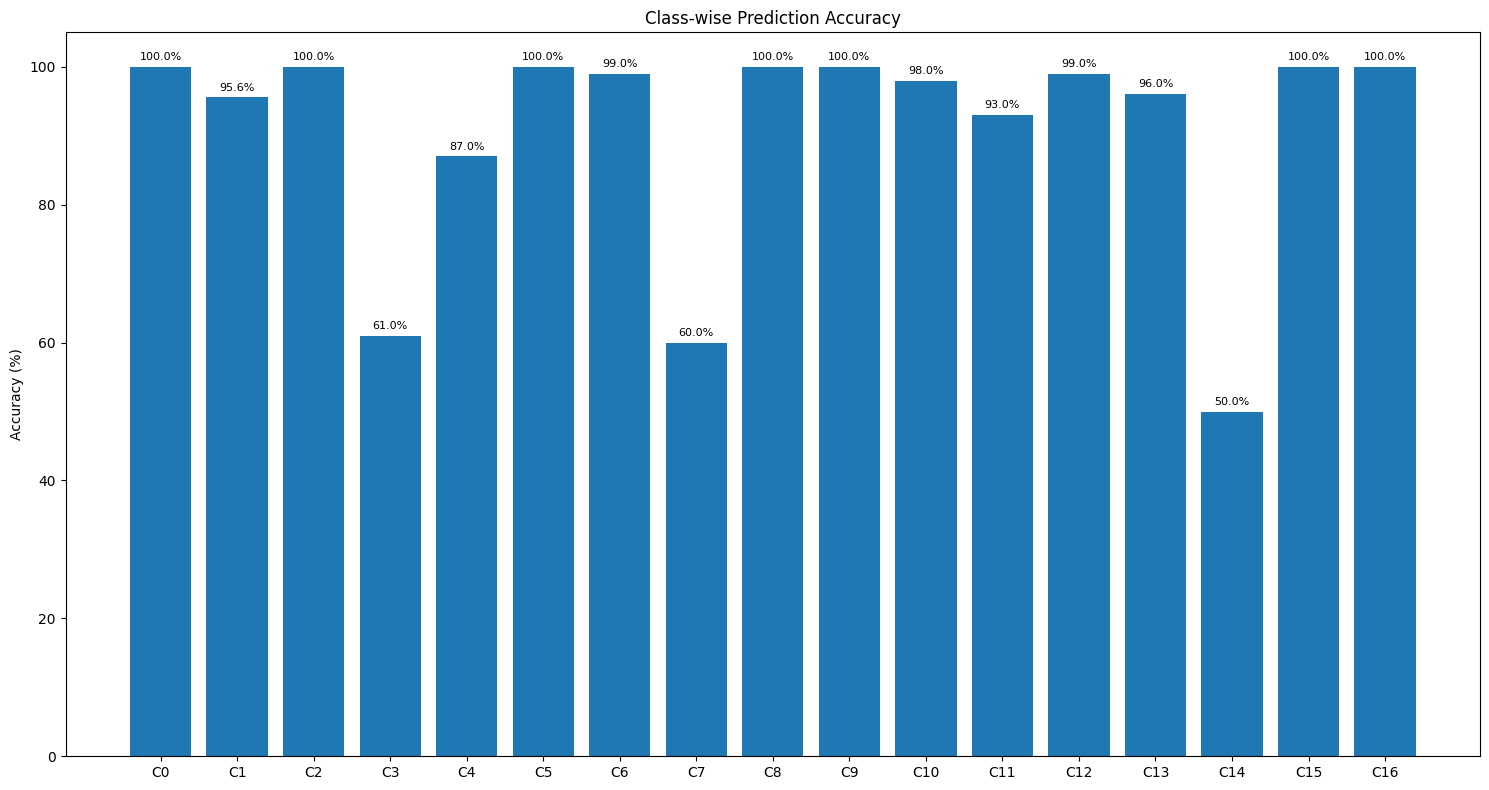

Worst 3 classes:
Class 14: 50.0%
Class 7: 60.0%
Class 3: 61.0%


In [11]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [15]:
# 모델 저장 - 현재 상태 그대로 저장
def save_models():
    """학습한 모델들을 저장"""
    
    # 저장 디렉토리 생성
    save_dir = "models"
    os.makedirs(save_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("🚨 모델 저장 시작...")
    
    # 각 fold별 모델 저장 (fold_models 리스트가 있다고 가정)
    try:
        for fold in range(5):  # 5-fold라고 가정
            model_path = f"{save_dir}/fold_{fold}_model_{timestamp}.pth"
            
            # fold_models[fold]가 존재한다면 저장
            if 'fold_models' in globals() and len(fold_models) > fold:
                torch.save({
                    'model_state_dict': fold_models[fold].state_dict(),
                    'fold': fold,
                    'timestamp': timestamp,
                    'epoch': 'unknown',  # 에포크 정보 모르면 unknown
                }, model_path)
                print(f"✅ Fold {fold} 모델 저장 완료: {model_path}")
            
            # 또는 best_models 리스트가 있다면
            elif 'best_models' in globals() and len(best_models) > fold:
                torch.save({
                    'model_state_dict': best_models[fold].state_dict(),
                    'fold': fold,
                    'timestamp': timestamp,
                    'epoch': 'unknown',
                }, model_path)
                print(f"✅ Fold {fold} best 모델 저장 완료: {model_path}")
                
    except Exception as e:
        print(f"❌ Fold별 저장 실패: {e}")
    
    # 전체 변수 상태 저장 (혹시 모르니까)
    try:
        state_path = f"{save_dir}/full_state_{timestamp}.pth"
        
        # 현재 글로벌 변수에서 모델 관련 객체들 찾아서 저장
        save_dict = {}
        
        # 가능한 모델 변수명들 체크
        possible_model_vars = ['model', 'models', 'fold_models', 'best_models', 
                              'tta_models', 'ensemble_models']
        
        for var_name in possible_model_vars:
            if var_name in globals():
                save_dict[var_name] = globals()[var_name]
                print(f"✅ {var_name} 변수 포함됨")
        
        if save_dict:
            torch.save(save_dict, state_path)
            print(f"✅ 전체 상태 저장 완료: {state_path}")
        
    except Exception as e:
        print(f"❌ 전체 상태 저장 실패: {e}")
    
    print(f"🎉 저장 완료! 저장 위치: {save_dir}/")
    print(f"📁 파일 목록:")
    for file in os.listdir(save_dir):
        print(f"   - {file}")

In [18]:
save_models()

🚨 모델 저장 시작...
❌ Fold별 저장 실패: 'collections.OrderedDict' object has no attribute 'state_dict'
✅ model 변수 포함됨
✅ fold_models 변수 포함됨
✅ ensemble_models 변수 포함됨
✅ 전체 상태 저장 완료: models/full_state_20250909_160737.pth
🎉 저장 완료! 저장 위치: models/
📁 파일 목록:
   - full_state_20250909_160737.pth


In [ ]:
# # 오답 데이터 분석 및 시각화
# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np

# def analyze_wrong_predictions(model, val_loader, device, num_samples=20):
#     """오답 데이터 분석 및 시각화"""
#     model.eval()
#     wrong_predictions = []
    
#     with torch.no_grad():
#         for images, targets in val_loader:
#             images, targets = images.to(device), targets.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
            
#             # 오답인 샘플들 찾기
#             wrong_mask = (preds != targets)
#             wrong_indices = torch.where(wrong_mask)[0]
            
#             for idx in wrong_indices:
#                 wrong_predictions.append({
#                     'image': images[idx].cpu(),
#                     'true_class': targets[idx].cpu().item(),
#                     'pred_class': preds[idx].cpu().item(),
#                     'confidence': torch.softmax(outputs[idx], 0).max().cpu().item()
#                 })
                
#                 if len(wrong_predictions) >= num_samples:
#                     break
            
#             if len(wrong_predictions) >= num_samples:
#                 break
    
#     return wrong_predictions

# def visualize_wrong_predictions(wrong_predictions, class_names, rows=4, cols=5):
#     """오답 데이터 시각화"""
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
#     axes = axes.flatten()
    
#     for i, wrong_pred in enumerate(wrong_predictions[:rows*cols]):
#         if i >= len(axes):
#             break
            
#         # 이미지 전처리 (정규화 해제)
#         img = wrong_pred['image'].permute(1, 2, 0)
#         img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
#         img = torch.clamp(img, 0, 1)
        
#         axes[i].imshow(img)
#         axes[i].set_title(f"True: {wrong_pred['true_class']} | "
#                          f"Pred: {wrong_pred['pred_class']}\n"
#                          f"Conf: {wrong_pred['confidence']:.3f}", 
#                          fontsize=10)
#         axes[i].axis('off')
    
#     # 빈 subplot 제거
#     for i in range(len(wrong_predictions), len(axes)):
#         axes[i].remove()
    
#     plt.tight_layout()
#     plt.savefig('wrong_predictions_analysis.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def print_wrong_class_summary(wrong_predictions):
#     """오답 클래스 요약 출력"""
#     from collections import Counter
    
#     true_classes = [wp['true_class'] for wp in wrong_predictions]
#     pred_classes = [wp['pred_class'] for wp in wrong_predictions]
    
#     print("=== 오답 분석 요약 ===")
#     print("실제 클래스별 오답 빈도:")
#     true_counter = Counter(true_classes)
#     for class_id, count in sorted(true_counter.items()):
#         print(f"  클래스 {class_id}: {count}개 오답")
    
#     print("\n예측 클래스별 오답 빈도:")
#     pred_counter = Counter(pred_classes)
#     for class_id, count in sorted(pred_counter.items()):
#         print(f"  클래스 {class_id}로 오예측: {count}개")
    
#     print(f"\n총 분석된 오답 수: {len(wrong_predictions)}개")

# # 실행 코드
# print("오답 데이터 분석 시작...")

# # 현재 best 모델로 오답 분석 (Fold 1 기준)
# wrong_preds = analyze_wrong_predictions(best_model, val_loader, device, num_samples=20)

# # 오답 요약 출력
# print_wrong_class_summary(wrong_preds)

# # 오답 이미지 시각화
# visualize_wrong_predictions(wrong_preds, class_names=None, rows=4, cols=5)

# print("오답 분석 완료!")

오답 데이터 분석 시작...


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [16]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [ ]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [ ]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [ ]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [ ]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [ ]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [ ]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 50/50 [17:13<00:00, 20.67s/it]


In [ ]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [ ]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [ ]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [ ]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
